# Comparison


In [1]:
import pandas as pd
import numpy as np
import os
import pickle

pd.set_option("display.max_columns", None)

In [2]:
from scripts.params import get_params
from scripts.aux_functions import get_all_results_matching, subset_of_columns, clean_modelname

params = get_params()

In [3]:
from scripts.epftoolbox_dm_gw import DM, plot_multivariate_DM_test, GW, plot_multivariate_GW_test

In [4]:
dataroute = params["dataroute"]
resultsroute = params["resultsroute"]
dumproute = params["dumproute"]
graphsroute = params["graphsroute"]
dmroute=params["dmroute"]
gwroute=params["gwroute"]

In [5]:
start_test = params["start_test"]
local_suffix = params["local_suffix"]

In [6]:
name = f'finaldf_test_{params["tablename"]}.pickle'
filename = os.path.join(dataroute, name)
with open(filename, "rb") as handle:
    df_test = pickle.load(handle)
    
df_test.index=pd.to_datetime(df_test.index.copy())

In [16]:
all_forecasts = get_all_results_matching(params["resultsroute"], ["best_forecasts"])
all_residuals = get_all_results_matching(params["resultsroute"], ["best_residuals"])

{'GARCH_BR_^BVSP_aic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\GARCH_BR_^BVSP_aic_best_forecasts.pickle', 'GARCH_BR_^BVSP_bic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\GARCH_BR_^BVSP_bic_best_forecasts.pickle', 'HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle', 'HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle', 'HMM_univ_BR_^BVSP_aic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_univ_BR_^BVSP_aic_best_forecasts.pickle', 'HMM_univ_BR_^BVSP_bic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_univ_BR_^BVSP_bic_best_forecasts.pickle', 'HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle', 'HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle', 'VAR_multiv_BR_^BVSP_aic_best_forecasts.pickle': '.

In [17]:
def get_only_log_rets(dict_with_dfs: dict, stock: str):
    if type(dict_with_dfs[stock]) == pd.Series:
        # univariate models are saved as series
        df = pd.DataFrame(dict_with_dfs[stock])

    else:
        try:
            # multivariate models are saved as dataframes
            df = pd.DataFrame(dict_with_dfs[stock][f"{stock}_log_rets"])
        except:  # TODO: SACAR ESTO! Es un chanchullo pq hay algunas que son guardadas como None
            pass
    return df

In [18]:
def create_df_from_results_dict(results_dict:dict, substring_to_replace:str):
    created_df = pd.DataFrame()

    for name, dir in results_dict.items():
        dict_with_dfs = pd.read_pickle(dir)
        print(name)

        for stock in dict_with_dfs.keys():
            df = get_only_log_rets(dict_with_dfs, stock)

            modelname = clean_modelname(name, substring_to_replace, tablename=params["tablename"])

            df.columns = [modelname + "_" + stock]

            created_df = pd.merge(
                created_df, df, left_index=True, right_index=True, how="outer"
            )

    created_df.index = pd.to_datetime(created_df.index)
    created_df = created_df[created_df.index > start_test]
    return created_df

In [33]:
forecasts_df = create_df_from_results_dict(all_forecasts, "forecasts")

GARCH_BR_^BVSP_aic_best_forecasts.pickle
GARCH_BR_^BVSP_bic_best_forecasts.pickle
HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle
HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle
HMM_univ_BR_^BVSP_aic_best_forecasts.pickle
HMM_univ_BR_^BVSP_bic_best_forecasts.pickle
HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle
HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle
VAR_multiv_BR_^BVSP_aic_best_forecasts.pickle
VAR_multiv_BR_^BVSP_bic_best_forecasts.pickle
VAR_with_vol_BR_^BVSP_aic_best_forecasts.pickle
VAR_with_vol_BR_^BVSP_bic_best_forecasts.pickle


In [34]:
forecasts_df = pd.concat([forecasts_df, subset_of_columns(df_test, "log_rets")])

In [35]:
residual_df = create_df_from_results_dict(all_residuals, "residuals")

GARCH_BR_^BVSP_aic_best_residuals.pickle
GARCH_BR_^BVSP_bic_best_residuals.pickle
HMM_multiv_BR_^BVSP_aic_best_residuals.pickle
HMM_multiv_BR_^BVSP_bic_best_residuals.pickle
HMM_univ_BR_^BVSP_aic_best_residuals.pickle
HMM_univ_BR_^BVSP_bic_best_residuals.pickle
HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle
HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle
VAR_multiv_BR_^BVSP_aic_best_residuals.pickle
VAR_multiv_BR_^BVSP_bic_best_residuals.pickle
VAR_with_vol_BR_^BVSP_aic_best_residuals.pickle
VAR_with_vol_BR_^BVSP_bic_best_residuals.pickle


In [36]:
lower_date=pd.to_datetime(params["start_test"])+pd.Timedelta(days=1)
higher_date=pd.to_datetime(params["end_test"])-pd.Timedelta(days=1)
residual_df=residual_df[lower_date:higher_date].copy()
df_test = df_test[lower_date:higher_date].copy()
residual_df.head()

,GARCH_aic_^BVSP,GARCH_aic_VALE3.SA,GARCH_aic_VALE,GARCH_aic_PETR3.SA,GARCH_aic_PBR,GARCH_aic_EMBR3.SA,GARCH_aic_ERJ,GARCH_aic_ABEV3.SA,GARCH_aic_ABEV,GARCH_bic_^BVSP,GARCH_bic_VALE3.SA,GARCH_bic_VALE,GARCH_bic_PETR3.SA,GARCH_bic_PBR,GARCH_bic_EMBR3.SA,GARCH_bic_ERJ,GARCH_bic_ABEV3.SA,GARCH_bic_ABEV,HMM_multiv_aic_^BVSP,HMM_multiv_aic_VALE3.SA,HMM_multiv_aic_VALE,HMM_multiv_aic_PETR3.SA,HMM_multiv_aic_PBR,HMM_multiv_aic_EMBR3.SA,HMM_multiv_aic_ERJ,HMM_multiv_aic_ABEV3.SA,HMM_multiv_aic_ABEV,HMM_multiv_aic_USD_^BVSP,HMM_multiv_bic_^BVSP,HMM_multiv_bic_VALE3.SA,HMM_multiv_bic_VALE,HMM_multiv_bic_PETR3.SA,HMM_multiv_bic_PBR,HMM_multiv_bic_EMBR3.SA,HMM_multiv_bic_ERJ,HMM_multiv_bic_ABEV3.SA,HMM_multiv_bic_ABEV,HMM_multiv_bic_USD_^BVSP,HMM_univ_aic_^BVSP,HMM_univ_aic_VALE3.SA,HMM_univ_aic_VALE,HMM_univ_aic_PETR3.SA,HMM_univ_aic_PBR,HMM_univ_aic_EMBR3.SA,HMM_univ_aic_ERJ,HMM_univ_aic_ABEV3.SA,HMM_univ_aic_ABEV,HMM_univ_bic_^BVSP,HMM_univ_bic_VALE3.SA,HMM_univ_bic_VALE,HMM_univ_bic_PETR3.SA,HMM_univ_bic_PBR,HMM_univ_bic_EMBR3.SA,HMM_univ_bic_ERJ,HMM_univ_bic_ABEV3.SA,HMM_univ_bic_ABEV,HMM_with_vol_aic_^BVSP,HMM_with_vol_aic_VALE3.SA,HMM_with_vol_aic_VALE,HMM_with_vol_aic_PETR3.SA,HMM_with_vol_aic_PBR,HMM_with_vol_aic_EMBR3.SA,HMM_with_vol_aic_ERJ,HMM_with_vol_aic_ABEV3.SA,HMM_with_vol_aic_ABEV,HMM_with_vol_aic_USD_^BVSP,HMM_with_vol_bic_^BVSP,HMM_with_vol_bic_VALE3.SA,HMM_with_vol_bic_VALE,HMM_with_vol_bic_PETR3.SA,HMM_with_vol_bic_PBR,HMM_with_vol_bic_EMBR3.SA,HMM_with_vol_bic_ERJ,HMM_with_vol_bic_ABEV3.SA,HMM_with_vol_bic_ABEV,HMM_with_vol_bic_USD_^BVSP,VAR_multiv_aic_^BVSP,VAR_multiv_aic_VALE3.SA,VAR_multiv_aic_VALE,VAR_multiv_aic_PETR3.SA,VAR_multiv_aic_PBR,VAR_multiv_aic_EMBR3.SA,VAR_multiv_aic_ERJ,VAR_multiv_aic_ABEV3.SA,VAR_multiv_aic_ABEV,VAR_multiv_bic_^BVSP,VAR_multiv_bic_VALE3.SA,VAR_multiv_bic_VALE,VAR_multiv_bic_PETR3.SA,VAR_multiv_bic_PBR,VAR_multiv_bic_EMBR3.SA,VAR_multiv_bic_ERJ,VAR_multiv_bic_ABEV3.SA,VAR_multiv_bic_ABEV,VAR_with_vol_aic_^BVSP,VAR_with_vol_aic_VALE3.SA,VAR_with_vol_aic_VALE,VAR_with_vol_aic_PETR3.SA,VAR_with_vol_aic_PBR,VAR_with_vol_aic_EMBR3.SA,VAR_with_vol_aic_ERJ,VAR_with_vol_aic_ABEV3.SA,VAR_with_vol_aic_ABEV,VAR_with_vol_bic_^BVSP,VAR_with_vol_bic_VALE3.SA,VAR_with_vol_bic_VALE,VAR_with_vol_bic_PETR3.SA,VAR_with_vol_bic_PBR,VAR_with_vol_bic_EMBR3.SA,VAR_with_vol_bic_ERJ,VAR_with_vol_bic_ABEV3.SA,VAR_with_vol_bic_ABEV
2023-06-01,0.019043,0.020822,0.028554,0.027047,0.034731,0.018832,0.036980,-0.008961,0.010192,0.018774,0.021055,0.028852,0.027047,0.034731,0.018832,0.036980,-0.012545,0.010192,0.020355,0.021043,0.027142,0.028182,0.036867,0.022025,0.040175,-0.011784,0.010655,0.020374,0.020416,0.020379,0.028010,0.027874,0.036867,0.022329,0.039820,-0.009654,0.010408,0.019318,0.021200,0.021939,0.028283,0.027027,0.035455,0.019997,0.038099,-0.011928,0.010455,0.020473,0.021975,0.028250,0.027027,0.035455,0.019997,0.038099,-0.011878,0.010449,0.020244,0.021100,0.025633,0.024955,0.036218,0.021518,0.035422,-0.010249,0.008446,0.020244,0.017032,0.021100,0.025524,0.027593,0.036218,0.021518,0.038649,-0.012207,0.008446,0.017926,-0.007371,-0.004692,-0.007142,-0.018856,-0.023361,0.003868,-0.005980,-0.010202,-0.023113,-0.006800,-0.008214,-0.004970,-0.017764,-0.021952,0.003693,-0.007433,-0.004900,-0.013799,-0.008154,-0.008680,-0.012543,-0.009163,-0.013024,0.004523,-0.001870,-0.006891,-0.013985,-0.007229,-0.008111,-0.009569,-0.010697,-0.016144,0.006869,0.002302,-0.006959,-0.011648
2023-06-02,0.016491,0.040699,0.047466,0.010121,0.018605,-0.001133,0.006428,0.015512,0.027366,0.016639,0.040462,0.046952,0.010121,0.018605,-0.001133,0.006428,0.015335,0.027366,0.017462,0.041849,0.047901,0.011420,0.020266,0.001476,0.008995,0.015389,0.027720,0.017857,0.016876,0.041867,0.047901,0.012025,0.020931,0.002312,0.007982,0.015054,0.027440,0.017305,0.016916,0.039928,0.046074,0.009820,0.019059,-0.001337,0.006202,0.014827,0.027553,0.017901,0.038843,0.043631,0.009820,0.019059,-0.001337,0.006202,0.015240,0.027553,0.015028,0.041851,0.044870,0.010

In [37]:
# estadisticos de nans
((residual_df.isna().sum(axis=0) / len(residual_df.index)) * 100).nlargest(10)

GARCH_aic_^BVSP       0.0
GARCH_aic_VALE3.SA    0.0
GARCH_aic_VALE        0.0
GARCH_aic_PETR3.SA    0.0
GARCH_aic_PBR         0.0
GARCH_aic_EMBR3.SA    0.0
GARCH_aic_ERJ         0.0
GARCH_aic_ABEV3.SA    0.0
GARCH_aic_ABEV        0.0
GARCH_bic_^BVSP       0.0
dtype: float64

In [38]:
# estadisticos de nans
((forecasts_df.isna().sum(axis=0) / len(forecasts_df.index)) * 100).nlargest(10)

^BVSP_log_rets       50.972763
VALE3.SA_log_rets    50.972763
VALE_log_rets        50.972763
PETR3.SA_log_rets    50.972763
PBR_log_rets         50.972763
EMBR3.SA_log_rets    50.972763
ERJ_log_rets         50.972763
ABEV3.SA_log_rets    50.972763
ABEV_log_rets        50.972763
USD_log_rets         50.972763
dtype: float64

## Separating in different stocks

In [39]:
def separate_by_stock(df:pd.DataFrame):
     stock_dict={}

     for stock in params["tickerlist"]:
          if params["local_suffix"] in stock:
               stock_dict[stock]= subset_of_columns(residual_df, stock)
          else:
               stock_dict[stock]= subset_of_columns(residual_df, stock, params["local_suffix"])    
     
     return stock_dict      

In [40]:
forecasts_by_stock=separate_by_stock(forecasts_df)
residuals_by_stock=separate_by_stock(residual_df)

In [41]:
for df_clean, name in zip([forecasts_by_stock, residuals_by_stock], ["forecasts", "residuals"]):
    bystockname = name + "_by_stock_" + params["tablename"] + ".pickle"
    with open(os.path.join(resultsroute, bystockname), "wb") as handle:
        pickle.dump(df_clean, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
def delete_in_column_names(df:pd.DataFrame, string:str):
    new_cols=[]
    for col in df.columns:
        col=col.replace(string, "")
        new_cols.append(col)
    df=df.set_axis(labels=new_cols, axis=1)
    return df

^BVSP


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


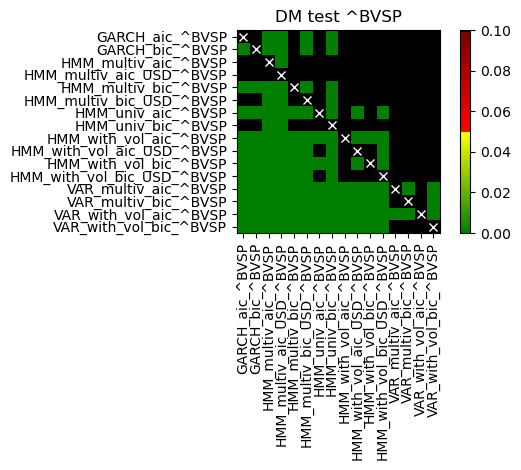

VALE3.SA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


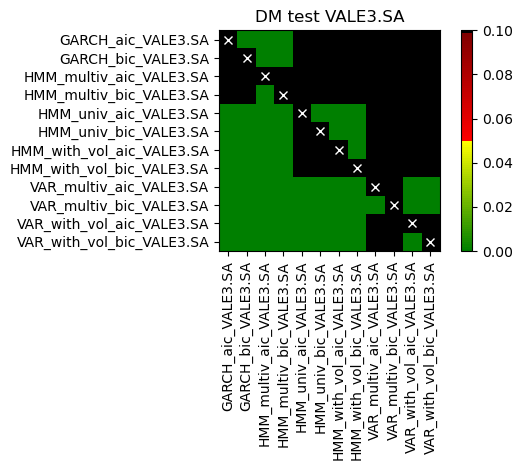

VALE


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


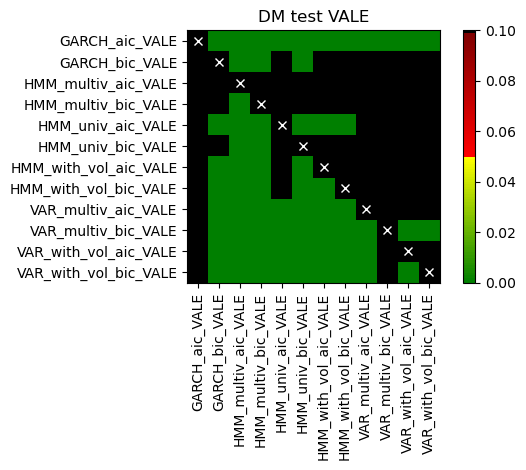

PETR3.SA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


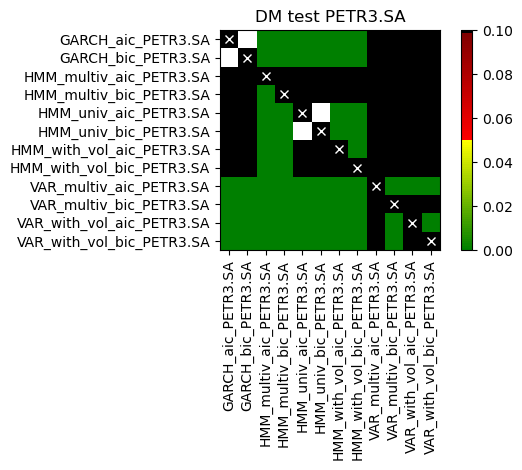

PBR


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


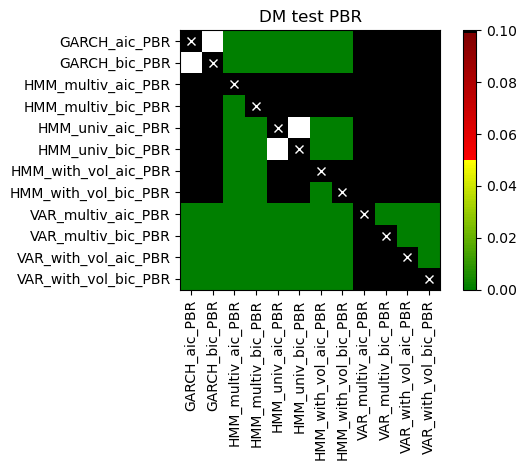

EMBR3.SA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


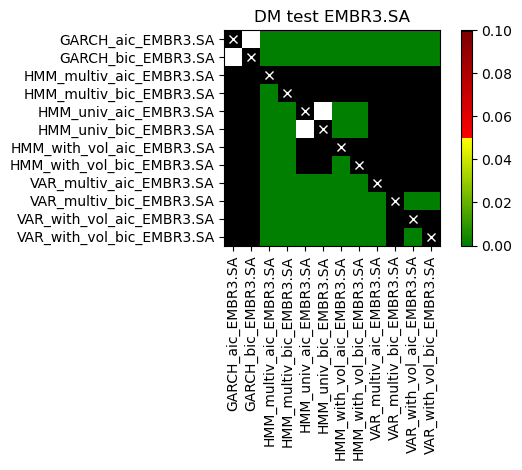

ERJ


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


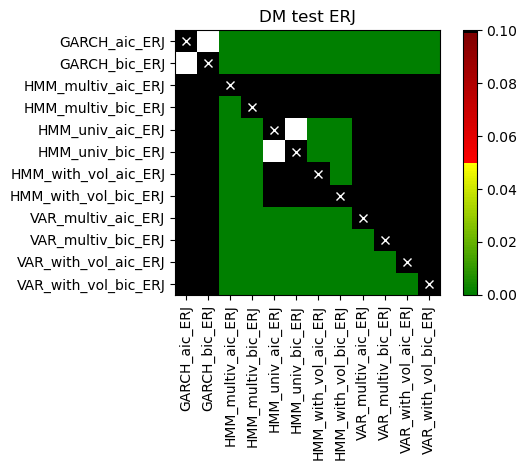

ABEV3.SA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


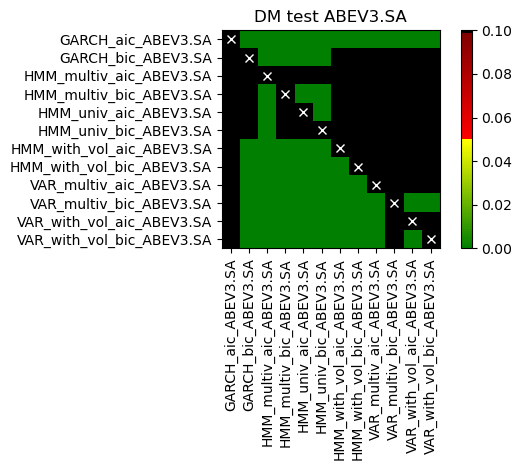

ABEV


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


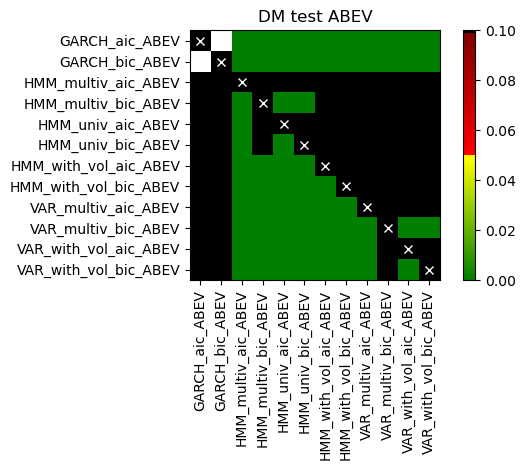

In [43]:
for stock in forecasts_by_stock.keys():
    print(stock)
    real_values=subset_of_columns(df_test, f"{stock}_log_rets")
    forecasts=delete_in_column_names(forecasts_by_stock[stock].fillna(0), f"__{stock}")   

    plot_multivariate_DM_test(real_price=real_values, 
                            forecasts=forecasts.fillna(0), 
                            title=f"DM test {stock}",
                            savefig=True,
                            path=dmroute)

In [65]:
best_models_by_stock={stock:None for stock in residuals_by_stock.keys()}

for stock, dataframe in residuals_by_stock.items():
    dataframe = delete_in_column_names(dataframe, f"_{stock}")
    metrics_df = pd.DataFrame(index=["mse", "meanabs", "medianabs"])

    for column in dataframe.columns:
        single_model=pd.DataFrame(dataframe[column])
        
        metrics_df.loc["mse", column] = (
            (single_model**2).mean().mean()
        )
        metrics_df.loc["meanabs", column] = (
            single_model.abs().mean().mean()
        )
        metrics_df.loc["medianabs", column] = (
            (single_model.abs()).median().median()
        )
    metrics_df = metrics_df * 100
        
    best_dict={}
    for criterion in metrics_df.index:
        best_dict[criterion] = metrics_df.iloc[metrics_df.index==criterion].idxmin(axis="columns").values[0]
        
    best_models_by_stock[stock]= (metrics_df, best_dict)

In [66]:
print(params["assetlist"][0])
best_models_by_stock[params["assetlist"][0]][1]

^BVSP


{'mse': 'HMM_with_vol_aic',
 'meanabs': 'HMM_with_vol_aic',
 'medianabs': 'HMM_with_vol_aic'}

In [67]:
best_models_by_stock[params["assetlist"][0]][0]

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_aic_USD,HMM_multiv_bic,HMM_multiv_bic_USD,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_aic_USD,HMM_with_vol_bic,HMM_with_vol_bic_USD,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
mse,0.009101,0.009093,0.009829,0.009809,0.009183,0.009290,0.009527,0.009806,0.007960,0.008148,0.008008,0.008192,0.009078,0.009733,0.009493,0.009456
meanabs,0.778143,0.778538,0.805789,0.805163,0.770558,0.777498,0.795006,0.805278,0.718461,0.730138,0.721451,0.735141,0.790001,0.804165,0.805269,0.799667
medianabs,0.657612,0.661486,0.673119,0.673406,0.640058,0.653028,0.661279,0.674464,0.559257,0.604324,0.580795,0.630690,0.723734,0.629709,0.700265,0.717628


In [68]:
best_models_by_stock[params["assetlist"][0]][0].rank(axis=1)

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_aic_USD,HMM_multiv_bic,HMM_multiv_bic_USD,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_aic_USD,HMM_with_vol_bic,HMM_with_vol_bic_USD,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
mse,7.0,6.0,16.0,15.0,8.0,9.0,12.0,14.0,1.0,3.0,2.0,4.0,5.0,13.0,11.0,10.0
meanabs,7.0,8.0,16.0,13.0,5.0,6.0,10.0,15.0,1.0,3.0,2.0,4.0,9.0,12.0,14.0,11.0
medianabs,8.0,10.0,11.0,12.0,6.0,7.0,9.0,13.0,1.0,3.0,2.0,5.0,16.0,4.0,14.0,15.0
